# Toto Fine-Tuning Evaluation

Compare zero-shot vs fine-tuned Toto model performance on nocturnal blood glucose forecasting.

**Task**: Predict 6 hours of nocturnal blood glucose (72 timesteps at 5-min intervals)
**Context**: 42 hours of historical data (504 timesteps)

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from safetensors.torch import load_file

from toto.model.toto import Toto
from toto.data.util.dataset import MaskedTimeseries
from toto.inference.forecaster import TotoForecaster

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


## Configuration

In [2]:
# Forecasting configuration
INTERVAL_MINS = 5
CONTEXT_LENGTH = 504  # 42 hours (matches training)
FORECAST_LENGTH = 72  # 6 hours nocturnal
TARGET_COL = ColumnNames.BG.value

# Model paths
notebook_dir = Path.cwd()
repo_root = (
    notebook_dir.parent.parent if "notebooks" in str(notebook_dir) else notebook_dir
)
MODEL_DIR = (
    repo_root / "trained_models/artifacts/_tsfm_testing/output_single_gpu_toto_lora"
)
MODEL_PATH = MODEL_DIR / "final_model" / "model.safetensors"

print(
    f"Context: {CONTEXT_LENGTH} steps ({CONTEXT_LENGTH * INTERVAL_MINS / 60:.1f} hours)"
)
print(
    f"Forecast: {FORECAST_LENGTH} steps ({FORECAST_LENGTH * INTERVAL_MINS / 60:.1f} hours)"
)
print(f"Model: {MODEL_PATH}")

Context: 504 steps (42.0 hours)
Forecast: 72 steps (6.0 hours)
Model: /u201/a46dsouz/nocturnal-hypo-gly-prob-forecast/trained_models/artifacts/_tsfm_testing/output_single_gpu_toto_lora/final_model/model.safetensors


## Load Models

In [3]:
# %%
# Load zero-shot model
print("Loading zero-shot Toto model...")
toto_zs = Toto.from_pretrained("Datadog/Toto-Open-Base-1.0")
toto_zs.to(device)
toto_zs.eval()
forecaster_zs = TotoForecaster(toto_zs.model)
print("✓ Zero-shot model loaded.")

Loading zero-shot Toto model...
✓ Zero-shot model loaded.


In [4]:
# Load fine-tuned model from Trainer-saved format
print(f"Loading fine-tuned model from: {MODEL_PATH}")

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

# Load saved state dict
saved_state = load_file(str(MODEL_PATH))

# Load base Toto model
print("Loading base Toto model...")
toto_ft = Toto.from_pretrained("Datadog/Toto-Open-Base-1.0")

# The saved keys have structure: toto.base_model.model.model.<path>
# We need to map to Toto's structure: model.<path>
print("Applying fine-tuned weights...")
prefix = "toto.base_model.model."
toto_state = toto_ft.state_dict()
updated_keys = 0

for saved_key, value in saved_state.items():
    # Skip LoRA adapter keys (already merged into base weights)
    if "lora_" in saved_key:
        continue

    # Remove the wrapper prefix to get the Toto key
    if saved_key.startswith(prefix):
        toto_key = saved_key[len(prefix) :]
        if toto_key in toto_state:
            toto_state[toto_key] = value
            updated_keys += 1

toto_ft.load_state_dict(toto_state)
print(f"Updated {updated_keys} base model weights")

toto_ft.to(device)
toto_ft.eval()
forecaster_ft = TotoForecaster(toto_ft.model)
print("Fine-tuned model loaded.")

Loading fine-tuned model from: /u201/a46dsouz/nocturnal-hypo-gly-prob-forecast/trained_models/artifacts/_tsfm_testing/output_single_gpu_toto_lora/final_model/model.safetensors
Loading base Toto model...
Applying fine-tuned weights...
Updated 84 base model weights
Fine-tuned model loaded.


## Load Validation Data

In [5]:
# Load validation data (held out from training)
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

print(f"Validation patients: {list(val_data.keys())}")
print(f"Total validation days: {sum(len(df) // 288 for df in val_data.values())}")

2026-01-14T01:40:23 - ============================================================
2026-01-14T01:40:23 - Beginning data loading process with the following parmeters:
2026-01-14T01:40:23 - 	Dataset: kaggle_brisT1D - train
2026-01-14T01:40:23 - 	Columns: None
2026-01-14T01:40:23 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-14T01:40:23 - 	Number of validation days: 20
2026-01-14T01:40:23 - 	In parallel with up to 3 workers.

2026-01-14T01:40:23 - Loaded full processed data from cache for 9 patients
2026-01-14T01:40:23 - Loaded existing train/validation split from cache for 9 patients


Validation patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']
Total validation days: 138


## Helper Functions

In [6]:
def compute_metrics(predictions, targets):
    """Compute RMSE and MAE."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
    }


def forecast(context, timestamps, forecaster, prediction_length, num_samples=100):
    """Run Toto forecast and return median + quantiles."""
    series = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
    ts_seconds = (
        torch.tensor([ts.timestamp() for ts in timestamps], dtype=torch.float32)
        .unsqueeze(0)
        .to(device)
    )

    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_seconds,
        time_interval_seconds=torch.tensor(
            [INTERVAL_MINS * 60], dtype=torch.float32
        ).to(device),
    )

    with torch.no_grad():
        fc = forecaster.forecast(
            inputs,
            prediction_length=prediction_length,
            num_samples=num_samples,
            samples_per_batch=50,
        )

    return (
        fc.median.cpu().numpy()[0].flatten(),
        fc.quantile(0.1).cpu().numpy()[0].flatten(),
        fc.quantile(0.9).cpu().numpy()[0].flatten(),
    )

## Evaluate Both Models

In [7]:
# Evaluate both models on all valid validation days
results = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    df = patient_df.sort_index()
    if TARGET_COL not in df.columns:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(df):
        target = nocturnal[TARGET_COL].values[:FORECAST_LENGTH]
        if np.isnan(target).any() or len(target) < FORECAST_LENGTH:
            continue

        # Get context ending at midnight
        nocturnal_start = nocturnal.index[0]
        available = df.loc[df.index < nocturnal_start, TARGET_COL].dropna()

        if len(available) < CONTEXT_LENGTH:
            continue  # Not enough history

        context = available.iloc[-CONTEXT_LENGTH:].values
        timestamps = available.iloc[-CONTEXT_LENGTH:].index

        if np.isnan(context).any():
            continue

        # Zero-shot prediction
        pred_zs, q10_zs, q90_zs = forecast(
            context, timestamps, forecaster_zs, FORECAST_LENGTH
        )

        # Fine-tuned prediction
        pred_ft, q10_ft, q90_ft = forecast(
            context, timestamps, forecaster_ft, FORECAST_LENGTH
        )

        results.append(
            {
                "patient": patient_id,
                "target": target.flatten(),
                "context": context,
                "pred_zs": pred_zs,
                "q10_zs": q10_zs,
                "q90_zs": q90_zs,
                "pred_ft": pred_ft,
                "q10_ft": q10_ft,
                "q90_ft": q90_ft,
            }
        )

print(f"Evaluated {len(results)} validation days")

Evaluated 99 validation days


## Results Summary

In [8]:
# Per-patient metrics
print("Per-Patient Results:")
print("=" * 70)
print(
    f"{'Patient':<10} {'Days':<6} {'ZS RMSE':<12} {'FT RMSE':<12} {'Improvement':<12}"
)
print("-" * 70)

patient_stats = []
for pid in sorted(set(r["patient"] for r in results)):
    patient_days = [r for r in results if r["patient"] == pid]

    preds_zs = np.concatenate([r["pred_zs"] for r in patient_days])
    preds_ft = np.concatenate([r["pred_ft"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])

    rmse_zs = compute_metrics(preds_zs, targets)["rmse"]
    rmse_ft = compute_metrics(preds_ft, targets)["rmse"]
    improvement = (rmse_zs - rmse_ft) / rmse_zs * 100

    patient_stats.append(
        {
            "patient": pid,
            "days": len(patient_days),
            "rmse_zs": rmse_zs,
            "rmse_ft": rmse_ft,
            "improvement": improvement,
        }
    )

    print(
        f"{pid:<10} {len(patient_days):<6} {rmse_zs:<12.3f} {rmse_ft:<12.3f} {improvement:+.1f}%"
    )

# Overall metrics
all_preds_zs = np.concatenate([r["pred_zs"] for r in results])
all_preds_ft = np.concatenate([r["pred_ft"] for r in results])
all_targets = np.concatenate([r["target"] for r in results])

overall_zs = compute_metrics(all_preds_zs, all_targets)
overall_ft = compute_metrics(all_preds_ft, all_targets)

print("-" * 70)
print(
    f"{'OVERALL':<10} {len(results):<6} {overall_zs['rmse']:<12.3f} {overall_ft['rmse']:<12.3f} ",
    end="",
)
print(f"{(overall_zs['rmse'] - overall_ft['rmse']) / overall_zs['rmse'] * 100:+.1f}%")
print("=" * 70)

Per-Patient Results:
Patient    Days   ZS RMSE      FT RMSE      Improvement 
----------------------------------------------------------------------
p02        16     3.158        3.121        +1.2%
p03        17     3.119        3.090        +0.9%
p04        17     1.709        1.720        -0.6%
p10        17     1.414        1.410        +0.3%
p11        16     2.433        2.447        -0.5%
p12        16     2.513        2.534        -0.8%
----------------------------------------------------------------------
OVERALL    99     2.471        2.463        +0.3%


In [9]:
# Summary table
summary_df = pd.DataFrame(
    [
        {
            "Model": "Zero-Shot",
            "RMSE (mmol/L)": overall_zs["rmse"],
            "MAE (mmol/L)": overall_zs["mae"],
        },
        {
            "Model": "Fine-Tuned (LoRA)",
            "RMSE (mmol/L)": overall_ft["rmse"],
            "MAE (mmol/L)": overall_ft["mae"],
        },
    ]
)
summary_df

,Model,RMSE (mmol/L),MAE (mmol/L)
0,Zero-Shot,2.470558,1.816683
1,Fine-Tuned (LoRA),2.463405,1.809104


## Visualization: All Days for a Patient

Patient p10: 17 validation days


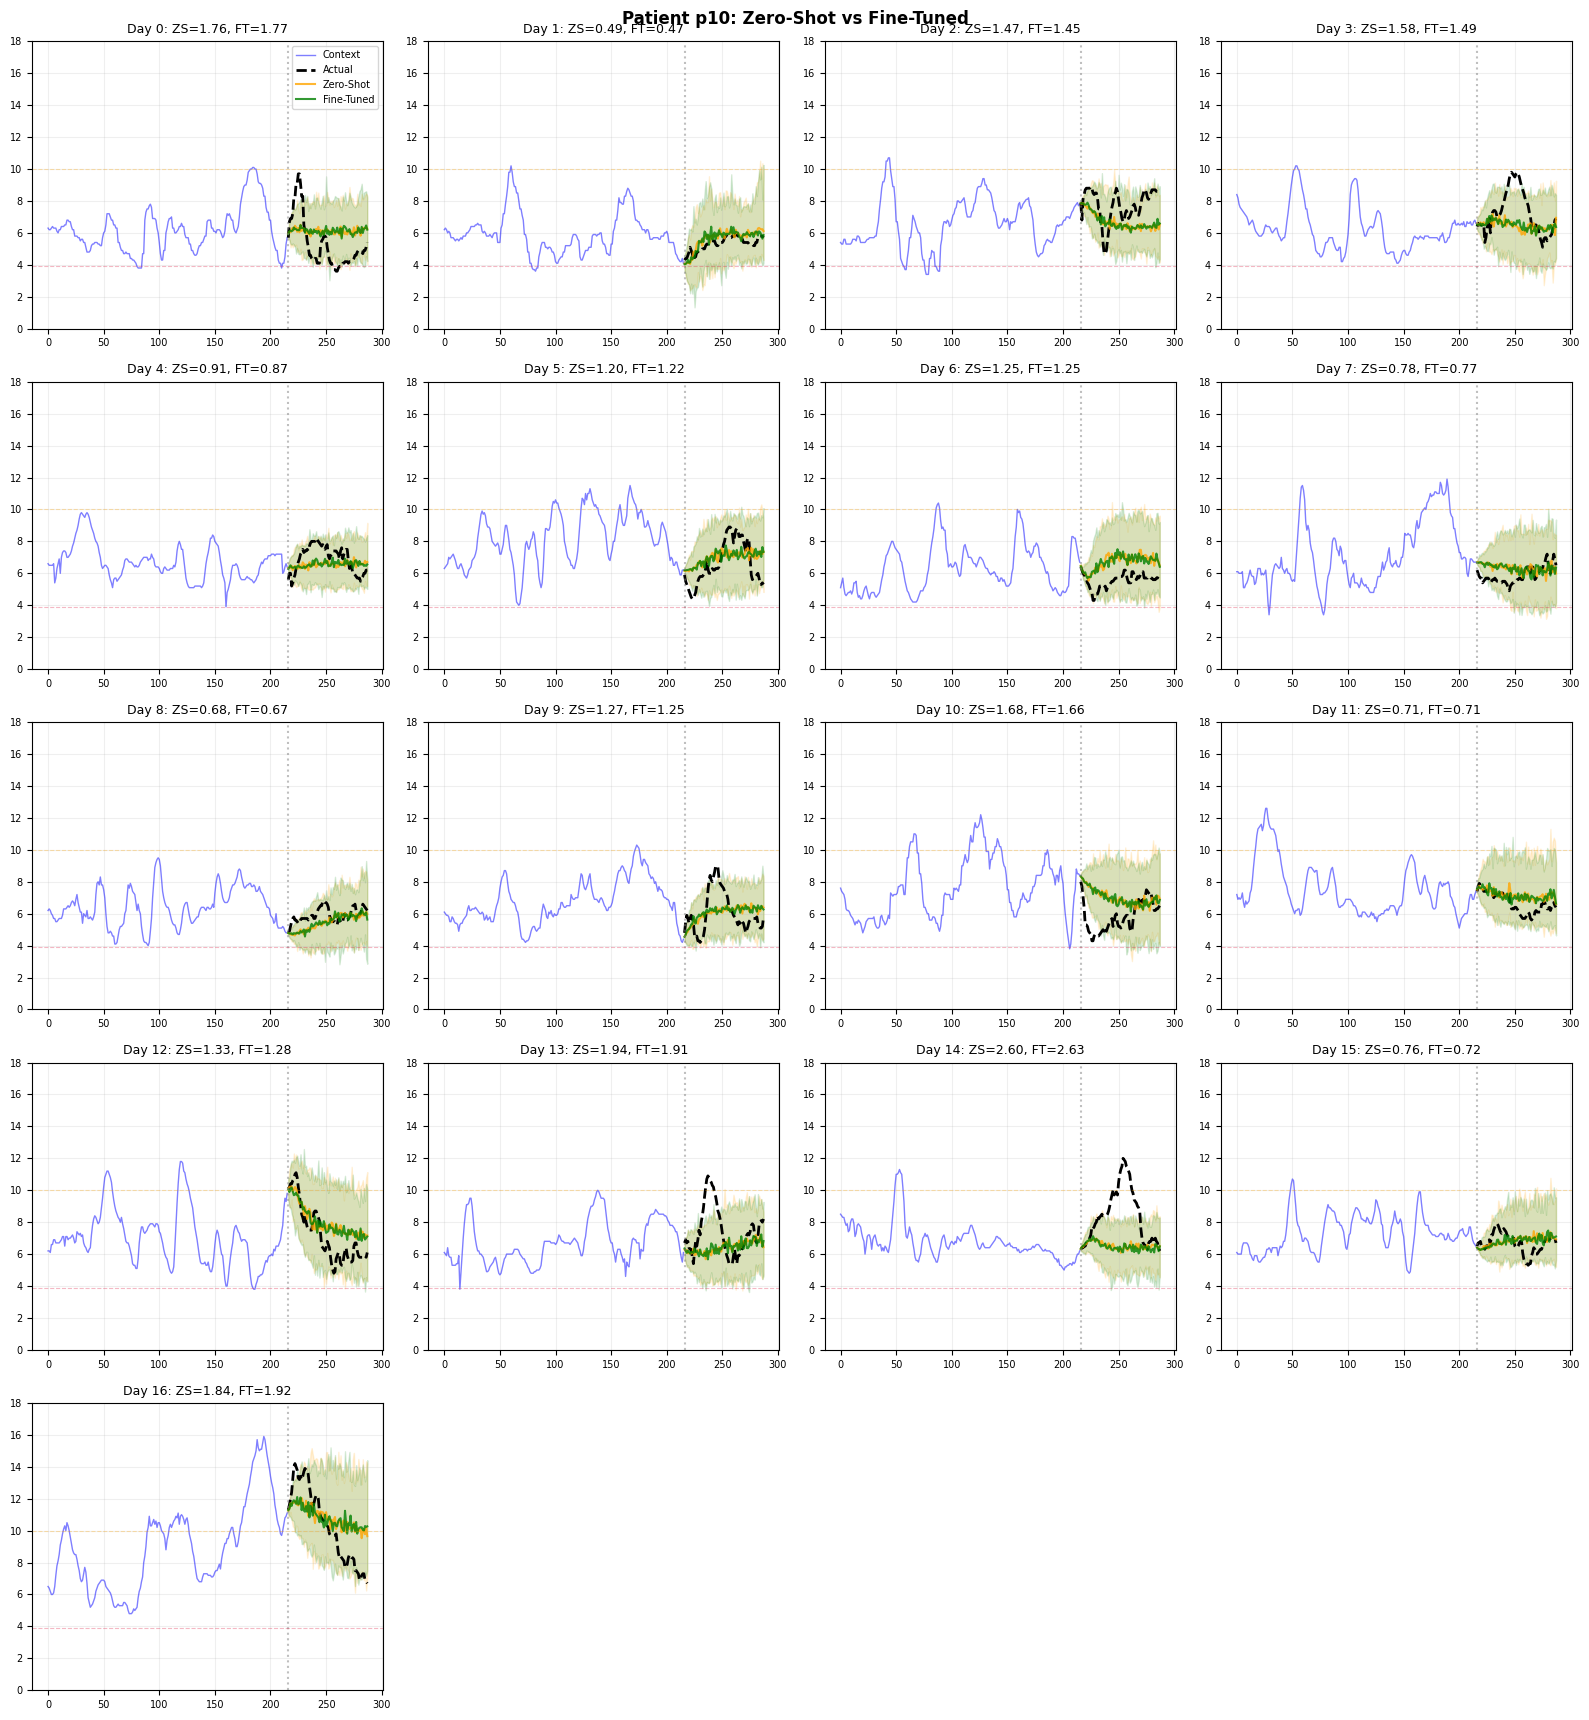

In [10]:
PLOT_PATIENT = "p10"  # Change to visualize different patient
NCOLS = 4

patient_results = [r for r in results if r["patient"] == PLOT_PATIENT]
num_days = len(patient_results)
print(f"Patient {PLOT_PATIENT}: {num_days} validation days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_results):
        ax = axes[i]

        # Show last 18h of context for cleaner visualization
        display_context = day["context"][-216:]
        target = day["target"]

        t_ctx = np.arange(len(display_context))
        t_pred = np.arange(len(display_context), len(display_context) + len(target))

        # Plot
        ax.plot(t_ctx, display_context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "k--", lw=2, label="Actual")
        ax.plot(t_pred, day["pred_zs"], "orange", lw=1.5, alpha=0.8, label="Zero-Shot")
        ax.fill_between(
            t_pred, day["q10_zs"], day["q90_zs"], alpha=0.15, color="orange"
        )
        ax.plot(t_pred, day["pred_ft"], "green", lw=1.5, alpha=0.8, label="Fine-Tuned")
        ax.fill_between(t_pred, day["q10_ft"], day["q90_ft"], alpha=0.15, color="green")

        # Reference lines
        ax.axvline(len(display_context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)  # Hypoglycemia
        ax.axhline(10.0, color="orange", ls="--", alpha=0.3, lw=0.8)  # Hyperglycemia

        # Metrics
        rmse_zs = compute_metrics(day["pred_zs"], target)["rmse"]
        rmse_ft = compute_metrics(day["pred_ft"], target)["rmse"]
        ax.set_title(f"Day {i}: ZS={rmse_zs:.2f}, FT={rmse_ft:.2f}", fontsize=9)

        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    # Hide empty subplots
    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(
        f"Patient {PLOT_PATIENT}: Zero-Shot vs Fine-Tuned",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

## Improvement Distribution

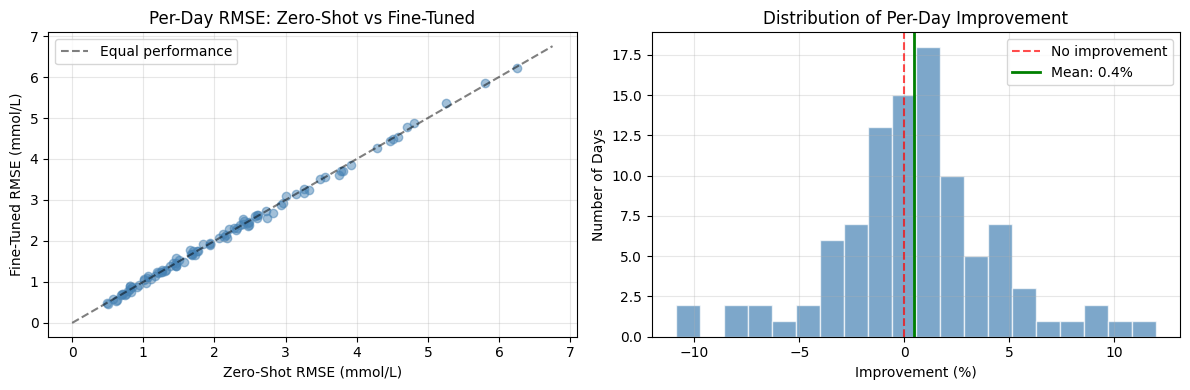

Days where fine-tuned is better: 55/99 (55.6%)
Average improvement: 0.44%
Median improvement: 0.39%


In [11]:
# Per-day RMSE comparison
day_rmse = []
for r in results:
    rmse_zs = compute_metrics(r["pred_zs"], r["target"])["rmse"]
    rmse_ft = compute_metrics(r["pred_ft"], r["target"])["rmse"]
    day_rmse.append({"rmse_zs": rmse_zs, "rmse_ft": rmse_ft, "patient": r["patient"]})

rmse_df = pd.DataFrame(day_rmse)
rmse_df["improvement"] = (
    (rmse_df["rmse_zs"] - rmse_df["rmse_ft"]) / rmse_df["rmse_zs"] * 100
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scatter plot: ZS vs FT RMSE per day
ax = axes[0]
ax.scatter(rmse_df["rmse_zs"], rmse_df["rmse_ft"], alpha=0.5, c="steelblue")
lims = [0, max(rmse_df["rmse_zs"].max(), rmse_df["rmse_ft"].max()) + 0.5]
ax.plot(lims, lims, "k--", alpha=0.5, label="Equal performance")
ax.set_xlabel("Zero-Shot RMSE (mmol/L)")
ax.set_ylabel("Fine-Tuned RMSE (mmol/L)")
ax.set_title("Per-Day RMSE: Zero-Shot vs Fine-Tuned")
ax.legend()
ax.grid(alpha=0.3)

# Histogram of improvement
ax = axes[1]
ax.hist(
    rmse_df["improvement"], bins=20, color="steelblue", alpha=0.7, edgecolor="white"
)
ax.axvline(0, color="red", ls="--", alpha=0.7, label="No improvement")
ax.axvline(
    rmse_df["improvement"].mean(),
    color="green",
    ls="-",
    lw=2,
    label=f"Mean: {rmse_df['improvement'].mean():.1f}%",
)
ax.set_xlabel("Improvement (%)")
ax.set_ylabel("Number of Days")
ax.set_title("Distribution of Per-Day Improvement")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
improved_days = (rmse_df["rmse_ft"] < rmse_df["rmse_zs"]).sum()
print(
    f"Days where fine-tuned is better: {improved_days}/{len(rmse_df)} ({100*improved_days/len(rmse_df):.1f}%)"
)
print(f"Average improvement: {rmse_df['improvement'].mean():.2f}%")
print(f"Median improvement: {rmse_df['improvement'].median():.2f}%")

## Training Details

**LoRA Configuration:**
- Rank: 16
- Alpha: 32
- Target modules: `wQKV`, `wO` (attention layers)
- Trainable parameters: ~1-2% of model

**Training Configuration:**
- Context: 504 steps (42 hours)
- Forecast: 72 steps (6 hours)
- Batch size: 16
- Learning rate: 1e-4
- Epochs: 10
- Dataset: kaggle_brisT1D training set